In [1]:
import numpy as np
import numpy.random as nrand
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import multiprocessing as mp

In [2]:
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [3]:
# Collect simulations whith initial mutant frequency A_init

def Simu(A_init, Ne=1000):

    # Effective populaiton size N
    N = Ne

    # Record whether the mutant get fixed or lost
    State_list = []

    # Geometric mean fitness
    fitness_gmean_list = []

    # Mean expected allele frequency change by selection
    dAF_mean_list = []

    # Effective fitness
    fitness_effective_list = []

    i = 0

    # Number of fixed simulations
    N_fixed = 0

    # Number of lost simulations
    N_lost = 0

    # Stop if at least 5000 simulations are collected for both categories.
    while (N_fixed < 50000) or (N_lost < 50000):
        # initially 500 mutant copies
        A = A_init

        s = 0.1

        # Pick initial fitness randomly.
        if nrand.uniform()<0.5:
            s = 1/(1+s)-1

        dAF_list = []
        fitness_list = []

        # Start evolution until fixation or loss.
        while True:
            # Switch fitness with probability of 0.05
            if nrand.uniform()<0.05:
                s = 1/(1+s)-1
            AF = A/N
            dAF = s*AF*(1-AF)/(1+s*AF)
            dAF_list.append(dAF)
            fitness_list.append(1+s)
            P = A*(1+s)/(s*A+N)
            A = nrand.binomial(N,p=P)
            if (A == N) or (A == 0):
                break

        fitness_gmean = np.product(fitness_list)**(1/len(fitness_list))

        dAF_mean = np.mean(dAF_list)

        fitness_effective = (1+2*dAF_mean)/(1-2*dAF_mean)

        if (A == N) and (N_fixed < 50000):
            State_list.append('fixed')
            N_fixed += 1
        elif (A == 0) and (N_lost < 50000):
            State_list.append('lost')
            N_lost += 1
        else:
            continue # If there is already 50000 simulations collected for the corresponding category, continue.

        fitness_gmean_list.append(fitness_gmean)
        fitness_effective_list.append(fitness_effective)
        dAF_mean_list.append(dAF_mean)

        # Keep track on number of simulations
        i += 1
        if i % 100 == 0:
            print(min(N_fixed,N_lost),end='\r',flush=True)

    fitness_effective_list = np.array(fitness_effective_list)
    fitness_gmean_list = np.array(fitness_gmean_list)
    State_list = np.array(State_list)
    
    return fitness_effective_list, fitness_gmean_list, State_list

In [12]:
# Get the ROC curve.
def get_ROC(pred_list,obs_list,N_percentile):
    FPR_list = []
    TPR_list = []
    for cutoff in np.concatenate([
        np.percentile(pred_list,q=np.linspace(0,100,N_percentile)),
        [np.max(pred_list)+0.001]]
    ):
        fixed_pred = pred_list >= cutoff
        FPR = (fixed_pred & (~obs_list)).sum()/(~obs_list).sum() # False positive rate
        TPR = (fixed_pred & obs_list).sum()/obs_list.sum() # True positive rate
        FPR_list.append(FPR)
        TPR_list.append(TPR)
    return FPR_list,TPR_list
    

In [5]:
# Simulations whith initial mutant frequency 0.01
fitness_effective_list, fitness_gmean_list, State_list = Simu(A_init=10)

# Get the ROC curve for geometric mean fitness
FPR_gmean_list,TPR_geman_list = get_ROC(fitness_gmean_list, (State_list == 'fixed'), N_percentile=51)

# Get the ROC curve for effective fitness
FPR_e_list,TPR_e_list = get_ROC(fitness_effective_list, (State_list == 'fixed'), N_percentile=51)

(-0.01, 1.01)

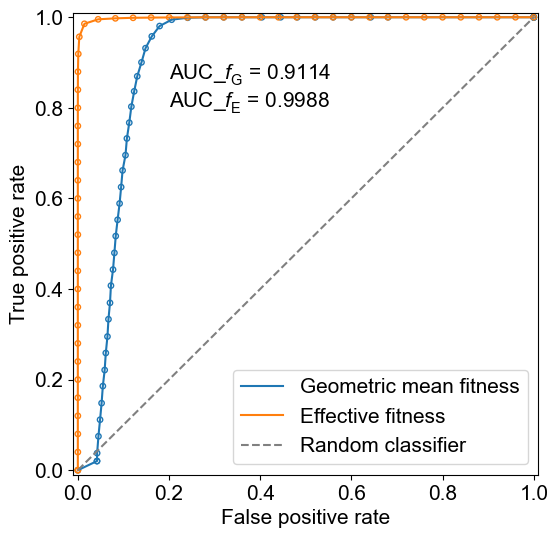

In [11]:
# Plot ROC for simulations with initial mutant frequency of 0.01

plt.subplots(figsize=[6,6])
plt.plot(FPR_gmean_list,TPR_geman_list,label='Geometric mean fitness')
plt.scatter(FPR_gmean_list,TPR_geman_list,s=15,facecolors='none', edgecolor='C0')
plt.plot(FPR_e_list,TPR_e_list,label='Effective fitness')
plt.scatter(FPR_e_list,TPR_e_list,s=15,facecolors='none', edgecolor='C1')

AUC_e = metrics.auc(FPR_e_list,TPR_e_list)
AUC_gmean = metrics.auc(FPR_gmean_list,TPR_geman_list)
plt.text(x=0.2,y=0.8,s="AUC_$\mathit{f}_G$ = "+f"{AUC_gmean:.4f}\n"+"AUC_$\mathit{f}_E$ = "+f"{AUC_e:.4f}")

plt.plot([0,1],[0,1],'--',color='gray',label='Random classifier')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
#plt.savefig('Figure3_D.pdf')

In [14]:
# Simulations whith initial mutant frequency 0.5
fitness_effective_list, fitness_gmean_list, State_list = Simu(A_init=500)

# Get the ROC curve for geometric mean fitness
FPR_gmean_list,TPR_geman_list = get_ROC(fitness_gmean_list, (State_list == 'fixed'), N_percentile=1501)

# Get the ROC curve for effective fitness
FPR_e_list,TPR_e_list = get_ROC(fitness_effective_list, (State_list == 'fixed'), N_percentile=1501)

(0.95, 1.001)

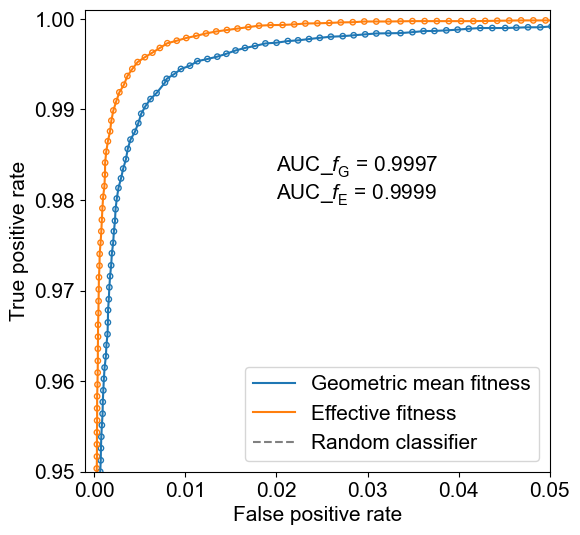

In [16]:
# Plot ROC for simulations with initial mutant frequency of 0.5

plt.subplots(figsize=[6,6])
plt.plot(FPR_gmean_list,TPR_geman_list,label='Geometric mean fitness')
plt.scatter(FPR_gmean_list,TPR_geman_list,s=15,facecolors='none', edgecolor='C0')
plt.plot(FPR_e_list,TPR_e_list,label='Effective fitness')
plt.scatter(FPR_e_list,TPR_e_list,s=15,facecolors='none', edgecolor='C1')

AUC_e = metrics.auc(FPR_e_list,TPR_e_list)
AUC_gmean = metrics.auc(FPR_gmean_list,TPR_geman_list)
plt.text(x=0.02,y=0.98,s="AUC_$\mathit{f}_G$ = "+f"{AUC_gmean:.4f}\n"+"AUC_$\mathit{f}_E$ = "+f"{AUC_e:.4f}")

plt.plot([0,1],[0,1],'--',color='gray',label='Random classifier')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

plt.xlim(-0.001,0.05)
plt.ylim(0.95,1.001)
#plt.savefig('FigureS2_C.pdf')

In [17]:
# Collect simulations whoes fE contradicts fG
def Simu_contradict(shared_dict,result_queue,i,A_ini):
    
    nrand.seed(i*17232)
    
    # Effective populaiton size N
    N = 1000
    
    # Record whether the mutant get fixed or lost
    State_list = []
    
    # Geometric mean fitness
    fitness_gmean_list = []
    
    # Mean expected allele frequency change by selection
    dAF_mean_list = []
    
    # Initialize shared dictionary between child processes to keep track on total number of collected simulations.
    # There are two categories:
    # "i_dAF_lt0" basically means fE is smaller than 1, but fG is greater than 1
    # "i_dAF_gt0" basically means fE is greater than 1, but fG is smaller than 1
    if 'i_dAF_lt0' not in shared_dict:
        shared_dict['i_dAF_lt0'] = 0
    if 'i_dAF_gt0' not in shared_dict:
        shared_dict['i_dAF_gt0'] = 0
        
    # Stop if at least 5000 simulations are collected for both categories.
    while (shared_dict['i_dAF_gt0'] < 5000) or (shared_dict['i_dAF_lt0'] < 5000):
        A = A_ini
        s = 0.1
        
        # Pick initial fitness randomly.
        if nrand.uniform()<0.5:
            s = 1/(1+s)-1

        dAF_list = []
        fitness_list = []
        
        # Start evolution until fixation or loss.
        while True:
            # Switch fitness with probability of 0.05
            if nrand.uniform()<0.05:
                s = 1/(1+s)-1
            AF = A/N
            dAF = s*AF*(1-AF)/(1+s*AF)
            dAF_list.append(dAF)
            fitness_list.append(1+s)
            P = A*(1+s)/(s*A+N)
            A = nrand.binomial(N,p=P)
            if (A == N) or (A == 0):
                break

        fitness_gmean = np.product(fitness_list)**(1/len(fitness_list))
        dAF_mean = np.mean(dAF_list)
        
        # If fG contradicts fE, collect this simulation.
        if ((fitness_gmean>1) and (dAF_mean<0) and (shared_dict['i_dAF_lt0'] < 5000)) or \
           ((fitness_gmean<1) and (dAF_mean>0) and (shared_dict['i_dAF_gt0'] < 5000)) :
            
            if A == N:
                State_list.append('fixed')
            else:
                State_list.append('lost')
            fitness_gmean_list.append(fitness_gmean)
            dAF_mean_list.append(dAF_mean)
            
            if (fitness_gmean>1) and (dAF_mean<0):
                shared_dict['i_dAF_lt0'] += 1
            elif (fitness_gmean<1) and (dAF_mean>0):
                shared_dict['i_dAF_gt0'] += 1
            
            # Print the minimum number of simulation collected among the two categories.
            N_min = min(shared_dict.values())
            if N_min % 10 == 0:
                print(N_min,end='\r',flush=True)
    
    # Put results in the return dictionary shared by child processes.
    result_queue.put({
        'fitness_gm':fitness_gmean_list,
        'dAF':dAF_mean_list,
        'state':State_list
    })

In [18]:
manager = mp.Manager()
result_queue = manager.Queue()

# Create a shared list using the Manager
shared_dict = manager.dict()

# Number of processes
num_processes = 10

# Create and start processes that will add values to the shared list
processes = [
    mp.Process(target=Simu_contradict, args=(shared_dict,result_queue,i,500))
    for i in range(num_processes)
]

for p in processes:
    p.start()

# Wait for all processes to finish
for p in processes:
    p.join()

results = [result_queue.get() for _ in range(result_queue.qsize())]

In [19]:
result_df = pd.concat(map(pd.DataFrame,results))

# Just use the first 5000 simulations of two category.
result_df = pd.concat([result_df[(result_df['dAF'] < 0)][0:5000],result_df[(result_df['dAF'] > 0)][0:5000]])

#result_df.to_csv('Fix_Loss_contradict.csv',index=False)

In [112]:
#result_df = pd.read_csv('Fix_Loss_contradict.csv')

In [20]:
# Number of simulations where fG>1, fE<1, the mutant fixed.
N_dAF_lt0_fixed = (result_df.loc[result_df['dAF']<0,'state'] == 'fixed').sum()
# Number of simulations where fG>1, fE<1, the mutant lost.
N_dAF_lt0_lost = (result_df.loc[result_df['dAF']<0,'state'] == 'lost').sum()
# Number of simulations where fG<1, fE>1, the mutant fixed.
N_dAF_gt0_fixed = (result_df.loc[result_df['dAF']>0,'state'] == 'fixed').sum()
# Number of simulations where fG<1, fE>1, the mutant lost.
N_dAF_gt0_lost = (result_df.loc[result_df['dAF']>0,'state'] == 'lost').sum()

(-0.5, 1.5)

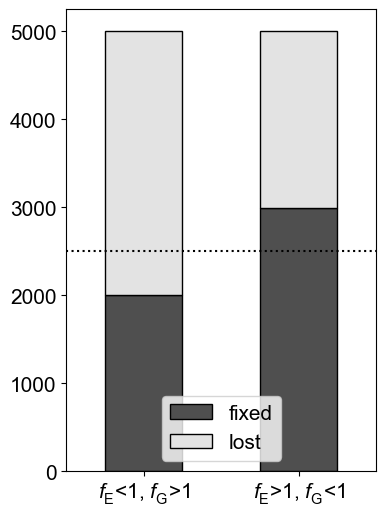

In [21]:
plt.subplots(figsize=[4,6])

plt.bar(
    x=['$\mathit{f}_{E}$<1, $\mathit{f}_{G}$>1','$\mathit{f}_{E}$<1, $\mathit{f}_{G}$>1'],
    height=[N_dAF_lt0_fixed,N_dAF_lt0_lost],
    bottom=[0,N_dAF_lt0_fixed],
    color=['#4F4F4F','#E3E3E3'], width=0.5
)

plt.bar(
    x=["$\mathit{f}_{E}$>1, $\mathit{f}_{G}$<1",'$\mathit{f}_{E}$>1, $\mathit{f}_{G}$<1'],
    height=[N_dAF_gt0_fixed,N_dAF_gt0_lost],
    bottom=[0,N_dAF_gt0_fixed],
    color=['#4F4F4F','#E3E3E3'], width=0.5, label=["fixed","lost"]
)

plt.hlines(y=2500,xmin=-0.5,xmax=1.5,ls='dotted',color='black')
plt.legend(loc='lower center',frameon=True)
plt.xlim(-0.5,1.5)

#plt.savefig('FigureS2_D.pdf')